In [800]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [1509]:
class ImagesDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = transforms.ToTensor()(img)
        img.close()
        return item.view(64 * 64)

    def __len__(self):
        return 100 #len(self.img_names)

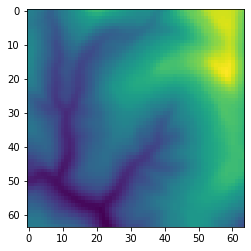

In [1510]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
plt.imshow(dataset[400].view(64, 64))
plt.show()

In [1511]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [1512]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_linear_1 = nn.Linear(64 * 64, 2048)
        self.enc_linear_2 = nn.Linear(2048, 1024)
        self.enc_linear_3_1 = nn.Linear(1024, 256)
        self.enc_linear_3_2 = nn.Linear(1024, 256)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(256, 1024)
        self.dec_linear_2 = nn.Linear(1024, 2048)
        self.dec_linear_3 = nn.Linear(2048, 64 * 64)
        
    def encode(self, data):
        x = F.relu(self.enc_linear_1(data))
        x = F.relu(self.enc_linear_2(x))
        return self.enc_linear_3_1(x), self.enc_linear_3_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def decode(self, code):
        out = F.relu(self.dec_linear_1(code))
        out = F.relu(self.dec_linear_2(out))
        out = torch.sigmoid(self.dec_linear_3(out))
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        code = self.reparametrize(mu, logvar)
        out = self.decode(code)
        return out, mu, logvar

In [1513]:
vae = VAE().cuda()

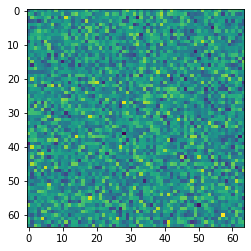

In [1514]:
x = dataset[400].cuda()
out, _, _ = vae(x)
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [1515]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 1000

for epoch in range(epochs):
    vae.train()
    for data in dataloader:
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
    print('epoch=' + str(epoch + 1) + ', loss=' + str(loss))

epoch=1, loss=tensor(13002.7871, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2, loss=tensor(8720.1904, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3, loss=tensor(7036.3892, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4, loss=tensor(7016.2642, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5, loss=tensor(6741.3838, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6, loss=tensor(7475.5986, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7, loss=tensor(7249.5586, device='cuda:0', grad_fn=<AddBackward0>)
epoch=8, loss=tensor(7284.0464, device='cuda:0', grad_fn=<AddBackward0>)
epoch=9, loss=tensor(5478.2861, device='cuda:0', grad_fn=<AddBackward0>)
epoch=10, loss=tensor(5820.1465, device='cuda:0', grad_fn=<AddBackward0>)
epoch=11, loss=tensor(5482.8677, device='cuda:0', grad_fn=<AddBackward0>)
epoch=12, loss=tensor(4451.3379, device='cuda:0', grad_fn=<AddBackward0>)
epoch=13, loss=tensor(5513.0889, device='cuda:0', grad_fn=<AddBackward0>)
epoch=14, loss=tensor(4603.8882, device='cuda:

epoch=114, loss=tensor(4125.8926, device='cuda:0', grad_fn=<AddBackward0>)
epoch=115, loss=tensor(3236.6260, device='cuda:0', grad_fn=<AddBackward0>)
epoch=116, loss=tensor(3583.5999, device='cuda:0', grad_fn=<AddBackward0>)
epoch=117, loss=tensor(4588.1191, device='cuda:0', grad_fn=<AddBackward0>)
epoch=118, loss=tensor(4355.2896, device='cuda:0', grad_fn=<AddBackward0>)
epoch=119, loss=tensor(3323.5479, device='cuda:0', grad_fn=<AddBackward0>)
epoch=120, loss=tensor(2887.3643, device='cuda:0', grad_fn=<AddBackward0>)
epoch=121, loss=tensor(3224.4175, device='cuda:0', grad_fn=<AddBackward0>)
epoch=122, loss=tensor(3190.2769, device='cuda:0', grad_fn=<AddBackward0>)
epoch=123, loss=tensor(3652.8662, device='cuda:0', grad_fn=<AddBackward0>)
epoch=124, loss=tensor(4004.7361, device='cuda:0', grad_fn=<AddBackward0>)
epoch=125, loss=tensor(3850.8982, device='cuda:0', grad_fn=<AddBackward0>)
epoch=126, loss=tensor(3450.7144, device='cuda:0', grad_fn=<AddBackward0>)
epoch=127, loss=tensor(35

epoch=226, loss=tensor(3856.9102, device='cuda:0', grad_fn=<AddBackward0>)
epoch=227, loss=tensor(3575.9338, device='cuda:0', grad_fn=<AddBackward0>)
epoch=228, loss=tensor(2578.6477, device='cuda:0', grad_fn=<AddBackward0>)
epoch=229, loss=tensor(2594.7737, device='cuda:0', grad_fn=<AddBackward0>)
epoch=230, loss=tensor(2475.5449, device='cuda:0', grad_fn=<AddBackward0>)
epoch=231, loss=tensor(2687.9790, device='cuda:0', grad_fn=<AddBackward0>)
epoch=232, loss=tensor(3735.8115, device='cuda:0', grad_fn=<AddBackward0>)
epoch=233, loss=tensor(3664.5127, device='cuda:0', grad_fn=<AddBackward0>)
epoch=234, loss=tensor(2739.1724, device='cuda:0', grad_fn=<AddBackward0>)
epoch=235, loss=tensor(2876.3335, device='cuda:0', grad_fn=<AddBackward0>)
epoch=236, loss=tensor(2715.7576, device='cuda:0', grad_fn=<AddBackward0>)
epoch=237, loss=tensor(3120.8252, device='cuda:0', grad_fn=<AddBackward0>)
epoch=238, loss=tensor(3088.7271, device='cuda:0', grad_fn=<AddBackward0>)
epoch=239, loss=tensor(27

epoch=336, loss=tensor(2332.2319, device='cuda:0', grad_fn=<AddBackward0>)
epoch=337, loss=tensor(2583.0757, device='cuda:0', grad_fn=<AddBackward0>)
epoch=338, loss=tensor(2650.2959, device='cuda:0', grad_fn=<AddBackward0>)
epoch=339, loss=tensor(2287.9167, device='cuda:0', grad_fn=<AddBackward0>)
epoch=340, loss=tensor(2869.6343, device='cuda:0', grad_fn=<AddBackward0>)
epoch=341, loss=tensor(3056.1086, device='cuda:0', grad_fn=<AddBackward0>)
epoch=342, loss=tensor(3074.1460, device='cuda:0', grad_fn=<AddBackward0>)
epoch=343, loss=tensor(2514.6421, device='cuda:0', grad_fn=<AddBackward0>)
epoch=344, loss=tensor(2283.1792, device='cuda:0', grad_fn=<AddBackward0>)
epoch=345, loss=tensor(3416.3857, device='cuda:0', grad_fn=<AddBackward0>)
epoch=346, loss=tensor(2737.1858, device='cuda:0', grad_fn=<AddBackward0>)
epoch=347, loss=tensor(2983.3262, device='cuda:0', grad_fn=<AddBackward0>)
epoch=348, loss=tensor(2734.4399, device='cuda:0', grad_fn=<AddBackward0>)
epoch=349, loss=tensor(25

epoch=446, loss=tensor(2032.9977, device='cuda:0', grad_fn=<AddBackward0>)
epoch=447, loss=tensor(2183.2271, device='cuda:0', grad_fn=<AddBackward0>)
epoch=448, loss=tensor(2361.3359, device='cuda:0', grad_fn=<AddBackward0>)
epoch=449, loss=tensor(2111.9255, device='cuda:0', grad_fn=<AddBackward0>)
epoch=450, loss=tensor(2478.9973, device='cuda:0', grad_fn=<AddBackward0>)
epoch=451, loss=tensor(2191.3816, device='cuda:0', grad_fn=<AddBackward0>)
epoch=452, loss=tensor(2302.1216, device='cuda:0', grad_fn=<AddBackward0>)
epoch=453, loss=tensor(2088.2200, device='cuda:0', grad_fn=<AddBackward0>)
epoch=454, loss=tensor(2064.3142, device='cuda:0', grad_fn=<AddBackward0>)
epoch=455, loss=tensor(2190.9456, device='cuda:0', grad_fn=<AddBackward0>)
epoch=456, loss=tensor(2338.7874, device='cuda:0', grad_fn=<AddBackward0>)
epoch=457, loss=tensor(2015.7593, device='cuda:0', grad_fn=<AddBackward0>)
epoch=458, loss=tensor(2009.1633, device='cuda:0', grad_fn=<AddBackward0>)
epoch=459, loss=tensor(22

epoch=559, loss=tensor(1711.2241, device='cuda:0', grad_fn=<AddBackward0>)
epoch=560, loss=tensor(1637.2915, device='cuda:0', grad_fn=<AddBackward0>)
epoch=561, loss=tensor(1678.5184, device='cuda:0', grad_fn=<AddBackward0>)
epoch=562, loss=tensor(1889.5522, device='cuda:0', grad_fn=<AddBackward0>)
epoch=563, loss=tensor(1905.3823, device='cuda:0', grad_fn=<AddBackward0>)
epoch=564, loss=tensor(1965.3823, device='cuda:0', grad_fn=<AddBackward0>)
epoch=565, loss=tensor(1674.5796, device='cuda:0', grad_fn=<AddBackward0>)
epoch=566, loss=tensor(1957.5626, device='cuda:0', grad_fn=<AddBackward0>)
epoch=567, loss=tensor(1812.2273, device='cuda:0', grad_fn=<AddBackward0>)
epoch=568, loss=tensor(1940.6658, device='cuda:0', grad_fn=<AddBackward0>)
epoch=569, loss=tensor(1988.0887, device='cuda:0', grad_fn=<AddBackward0>)
epoch=570, loss=tensor(1960.7261, device='cuda:0', grad_fn=<AddBackward0>)
epoch=571, loss=tensor(1902.9014, device='cuda:0', grad_fn=<AddBackward0>)
epoch=572, loss=tensor(16

epoch=669, loss=tensor(1315.1923, device='cuda:0', grad_fn=<AddBackward0>)
epoch=670, loss=tensor(1426.0006, device='cuda:0', grad_fn=<AddBackward0>)
epoch=671, loss=tensor(1320.0261, device='cuda:0', grad_fn=<AddBackward0>)
epoch=672, loss=tensor(1290.3289, device='cuda:0', grad_fn=<AddBackward0>)
epoch=673, loss=tensor(1168.0143, device='cuda:0', grad_fn=<AddBackward0>)
epoch=674, loss=tensor(1204.9141, device='cuda:0', grad_fn=<AddBackward0>)
epoch=675, loss=tensor(1338.0995, device='cuda:0', grad_fn=<AddBackward0>)
epoch=676, loss=tensor(1315.8411, device='cuda:0', grad_fn=<AddBackward0>)
epoch=677, loss=tensor(1168.6987, device='cuda:0', grad_fn=<AddBackward0>)
epoch=678, loss=tensor(1355.7927, device='cuda:0', grad_fn=<AddBackward0>)
epoch=679, loss=tensor(1185.3617, device='cuda:0', grad_fn=<AddBackward0>)
epoch=680, loss=tensor(1352.1282, device='cuda:0', grad_fn=<AddBackward0>)
epoch=681, loss=tensor(1200.3125, device='cuda:0', grad_fn=<AddBackward0>)
epoch=682, loss=tensor(12

epoch=780, loss=tensor(1218.5859, device='cuda:0', grad_fn=<AddBackward0>)
epoch=781, loss=tensor(1105.2507, device='cuda:0', grad_fn=<AddBackward0>)
epoch=782, loss=tensor(1096.5857, device='cuda:0', grad_fn=<AddBackward0>)
epoch=783, loss=tensor(950.9706, device='cuda:0', grad_fn=<AddBackward0>)
epoch=784, loss=tensor(1029.7766, device='cuda:0', grad_fn=<AddBackward0>)
epoch=785, loss=tensor(999.8086, device='cuda:0', grad_fn=<AddBackward0>)
epoch=786, loss=tensor(1158.1467, device='cuda:0', grad_fn=<AddBackward0>)
epoch=787, loss=tensor(998.2639, device='cuda:0', grad_fn=<AddBackward0>)
epoch=788, loss=tensor(1124.8853, device='cuda:0', grad_fn=<AddBackward0>)
epoch=789, loss=tensor(1070.3528, device='cuda:0', grad_fn=<AddBackward0>)
epoch=790, loss=tensor(1233.1768, device='cuda:0', grad_fn=<AddBackward0>)
epoch=791, loss=tensor(1216.9277, device='cuda:0', grad_fn=<AddBackward0>)
epoch=792, loss=tensor(1121.1469, device='cuda:0', grad_fn=<AddBackward0>)
epoch=793, loss=tensor(1122.

epoch=891, loss=tensor(1091.8290, device='cuda:0', grad_fn=<AddBackward0>)
epoch=892, loss=tensor(1109.8201, device='cuda:0', grad_fn=<AddBackward0>)
epoch=893, loss=tensor(1166.0662, device='cuda:0', grad_fn=<AddBackward0>)
epoch=894, loss=tensor(1260.6902, device='cuda:0', grad_fn=<AddBackward0>)
epoch=895, loss=tensor(971.7427, device='cuda:0', grad_fn=<AddBackward0>)
epoch=896, loss=tensor(1146.3040, device='cuda:0', grad_fn=<AddBackward0>)
epoch=897, loss=tensor(980.1279, device='cuda:0', grad_fn=<AddBackward0>)
epoch=898, loss=tensor(1046.6938, device='cuda:0', grad_fn=<AddBackward0>)
epoch=899, loss=tensor(946.8092, device='cuda:0', grad_fn=<AddBackward0>)
epoch=900, loss=tensor(1112.9778, device='cuda:0', grad_fn=<AddBackward0>)
epoch=901, loss=tensor(1150.1428, device='cuda:0', grad_fn=<AddBackward0>)
epoch=902, loss=tensor(1101.0138, device='cuda:0', grad_fn=<AddBackward0>)
epoch=903, loss=tensor(1167.4280, device='cuda:0', grad_fn=<AddBackward0>)
epoch=904, loss=tensor(983.9

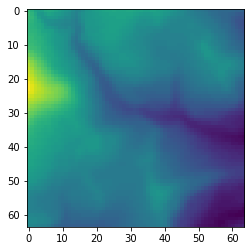

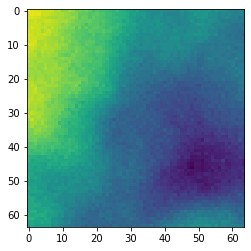

In [1526]:
x = dataset[100].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x)
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [1124]:
#torch.save(vae.state_dict(), './variational_autoencoder_save')

In [973]:
vae.load_state_dict(torch.load('./variational_autoencoder_save'))

<All keys matched successfully>

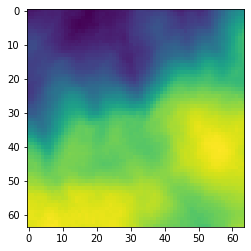

tensor([-1.7452,  0.7450, -0.8917, -0.6010, -1.0996,  0.1843,  1.4054,  0.1604,
         0.5222,  0.3211,  0.9483, -0.5409, -0.8707, -0.0294, -0.1012, -0.0307,
         0.6879, -0.4240, -0.3904, -0.5725, -1.6794,  1.0116,  1.3848,  1.3705,
        -0.6229, -1.4888, -0.7826, -1.1026, -2.2438,  0.7215,  0.9464, -0.0234,
         0.2243,  0.9515,  0.8110, -0.2812,  0.5454, -1.7509,  2.4960, -0.6550,
         1.7707,  0.6702,  1.3821,  2.2885, -0.3629,  1.9385, -1.0602, -0.0829,
        -0.1819, -1.4693, -0.8253,  0.4398,  0.1057,  1.1421, -0.0631,  0.4693,
         0.0558,  0.3195,  0.8993,  1.0437, -0.7037,  0.1727, -2.8506, -0.1171])


In [1496]:
# Generator
code = torch.FloatTensor(64).normal_()

out = vae.decode(code.cuda())
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()
print(code)